In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers


In [2]:
df_train = pd.read_csv('data/sign_mnist_train.csv')
df_test = pd.read_csv('data/sign_mnist_test.csv')

df_train.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
labels = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'.split()

df_train['letter_label'] = df_train['label'].apply(lambda x: labels[x])
df_test['letter_label'] = df_test['label'].apply(lambda x: labels[x])


In [4]:
df_train.shape, df_test.shape


((27455, 786), (7172, 786))

<Axes: title={'center': 'Data distribution'}, xlabel='letter_label'>

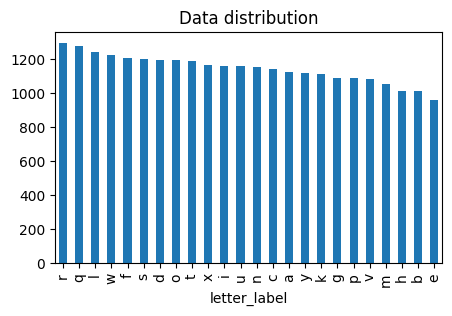

In [5]:
df_train['letter_label'].value_counts().plot.bar(title='Data distribution', figsize=(5, 3))


In [6]:
import numpy as np

try:
    df_train.drop(columns={'img'}, inplace=True)
    df_test.drop(columns={'img'}, inplace=True)
except:
    pass

pixels = [x for x in df_train.columns if 'pixel' in x]
df_train['img'] = df_train[pixels].values.tolist()
df_test['img'] = df_test[pixels].values.tolist()
df_train['img'] = df_train['img'].apply(lambda x: tf.convert_to_tensor(list(map(lambda y: int(y) / 255.0, x))))
df_test['img'] = df_test['img'].apply(lambda x: tf.convert_to_tensor(list(map(lambda y: int(y) / 255.0, x))))


2023-12-12 21:10:34.105651: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-12 21:10:34.105677: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-12 21:10:34.105683: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-12 21:10:34.105725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 21:10:34.105745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Text(0.5, 1.0, 's')

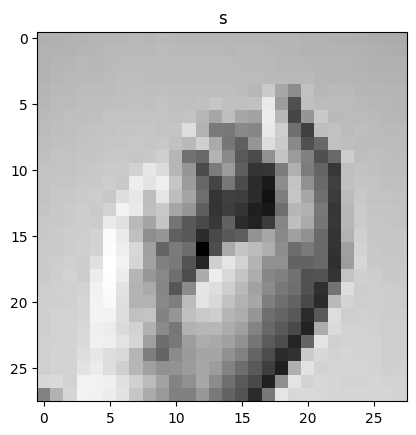

In [16]:
import random

idx = random.randint(0, len(df_train))

img = np.array(df_train['img'][idx]).reshape(28, 28)
label = df_train['letter_label'][idx]

plt.imshow(img, cmap='gray')
plt.title(label)

In [15]:
x = ", ".join(map(str, list(img.reshape(784))))
result = "float out[784] = {" + x + "};"

with open("../src/test.h", "w") as f:
    f.write(result)

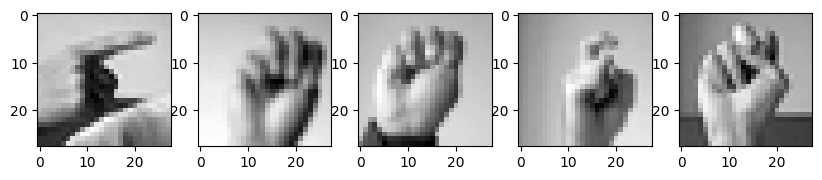

In [7]:

fig, axis = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))

for i in range(5):
    axis[i].imshow(np.array(random.choice(df_train['img'])).reshape(28, 28), cmap='gray')


In [8]:

def create_dataset(df) -> tf.data.Dataset:
    images = df['img'].values.tolist()
    labels = df['label'].values.tolist()

    images = list(map(lambda x: tf.reshape(x, (28, 28, 1)), images))

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset, test_raw_dataset = create_dataset(df_train), create_dataset(df_test)


In [52]:
DEBUG = False 

if not DEBUG:
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(26, activation='softmax')
    ])

else:
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(26, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 128)        

In [9]:
batch_size = 32
train_dataset = train_dataset.shuffle(len(df_train)).batch(batch_size)
test_dataset = test_raw_dataset.batch(batch_size)


In [54]:
if DEBUG:
    epochs = 1
else:
    epochs = 10
model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)


Epoch 1/10
858/858 [==============================] - 16s 16ms/step - loss: 1.1587 - accuracy: 0.6342 - val_loss: 0.2983 - val_accuracy: 0.9201
Epoch 2/10
858/858 [==============================] - 10s 12ms/step - loss: 0.1976 - accuracy: 0.9387 - val_loss: 0.4416 - val_accuracy: 0.9215
Epoch 3/10
858/858 [==============================] - 10s 11ms/step - loss: 0.1320 - accuracy: 0.9676 - val_loss: 0.4534 - val_accuracy: 0.9398
Epoch 4/10
858/858 [==============================] - 10s 11ms/step - loss: 0.1142 - accuracy: 0.9773 - val_loss: 0.6656 - val_accuracy: 0.9403
Epoch 5/10
858/858 [==============================] - 10s 11ms/step - loss: 0.1635 - accuracy: 0.9776 - val_loss: 0.9606 - val_accuracy: 0.9233
Epoch 6/10
858/858 [==============================] - 10s 11ms/step - loss: 0.1446 - accuracy: 0.9846 - val_loss: 1.9246 - val_accuracy: 0.8940
Epoch 7/10
858/858 [==============================] - 10s 11ms/step - loss: 0.1649 - accuracy: 0.9852 - val_loss: 1.8452 - val_accuracy:

In [55]:
model.save('models/test_saved')


INFO:tensorflow:Assets written to: models/test_saved/assets


INFO:tensorflow:Assets written to: models/test_saved/assets


In [10]:
# def representative_dataset():
#     for _ in range(100):
#       data = np.random.rand(1, 28, 28, 1)
#       yield [data.astype(np.float32)]

def representative_dataset():
    for data, _ in test_raw_dataset.shuffle(len(test_raw_dataset)).batch(1).take(500):
        yield [data]

In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model('models/test_saved')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# converter.representative_dataset = representative_dataset
tflite_quant_model = converter.convert()


2023-12-12 21:00:25.804367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-12 21:00:25.804381: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-12 21:00:25.805173: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: models/test_saved
2023-12-12 21:00:25.806697: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-12 21:00:25.806706: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: models/test_saved
2023-12-12 21:00:25.808778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-12 21:00:25.810128: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-12 21:00:25.865098: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/test_saved
2023

In [12]:
with open('models/test_saved/quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)


In [13]:
interpreter = tf.lite.Interpreter('models/test_saved/quant.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:
def predict(debug=True):
    random_idx = random.randint(0, len(df_test))
    input_data = np.array(df_test['img'][random_idx]).reshape(28, 28, 1).astype(np.float32)
    label = df_test['letter_label'][random_idx]

    interpreter.set_tensor(input_details[0]['index'], [input_data])
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    output_label = labels[tf.argmax(output_data[0])]

    if debug:
        print(f"Predicted: {output_label}, Expected: {label}")

    return output_label == label



In [19]:
results = []
for _ in range(1000):
    results.append(predict(debug=True))

print(f"Got {sum(results)} correct predictions out of {len(results)}")


Predicted: e, Expected: n
Predicted: b, Expected: b
Predicted: l, Expected: l
Predicted: r, Expected: r
Predicted: y, Expected: i
Predicted: w, Expected: w
Predicted: h, Expected: h
Predicted: y, Expected: y
Predicted: y, Expected: y
Predicted: m, Expected: m
Predicted: k, Expected: k
Predicted: i, Expected: i
Predicted: t, Expected: t
Predicted: l, Expected: l
Predicted: u, Expected: u
Predicted: f, Expected: f
Predicted: q, Expected: s
Predicted: s, Expected: s
Predicted: l, Expected: v
Predicted: p, Expected: p
Predicted: g, Expected: g
Predicted: c, Expected: c
Predicted: y, Expected: y
Predicted: w, Expected: w
Predicted: l, Expected: l
Predicted: n, Expected: n
Predicted: g, Expected: g
Predicted: c, Expected: c
Predicted: x, Expected: x
Predicted: m, Expected: m
Predicted: u, Expected: u
Predicted: w, Expected: w
Predicted: p, Expected: p
Predicted: m, Expected: m
Predicted: s, Expected: s
Predicted: g, Expected: g
Predicted: r, Expected: r
Predicted: i, Expected: i
Predicted: e

KeyError: 7172